# PROJECT PV211

## Requirements

In [1]:
%%capture
!pip -q install pandas torch torchvision matplotlib tqdm opencv-python scikit-learn seaborn 

In [2]:
import torch

# use cuda device if available
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(dev)

cuda


In [3]:
# Setting wrapping
from IPython.display import display
import pandas as pd

pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', None)        # don't wrap to next line
pd.set_option('display.max_colwidth', None) # for long text in cells

## Downloading data

Downloading the repository with the dataset from spMohanty/PlantVillage-Dataset.

In [4]:
import os
import requests
import zipfile

# Define dataset URL and paths
dataset_url = "https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip"
zip_path = "./master.zip"
extract_path = "./PlantVillage-Dataset-master"

redownload = False

# Download the dataset if not already downloaded
if (not os.path.exists(zip_path) and not os.path.exists(extract_path)) or redownload:
    print("Downloading dataset...")
    try:
        response = requests.get(dataset_url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download completed.")
    except Exception as e:
        print(f"Error downloading the dataset: {e}")
        exit(1)

# Extract the dataset if not already extracted
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    try:
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(".")
        print("Extraction completed.")
    except Exception as e:
        print(f"Error extracting the dataset: {e}")
        exit(1)

# Clean up the zip file
if os.path.exists(zip_path):
    os.remove(zip_path)
    print("Cleaned up zip file.")

print("Path to extracted files:", extract_path)

Path to extracted files: ./PlantVillage-Dataset-master


Following outliers were detected manually after casual visual inspection of dataset.

In [5]:
colors_outliers = ["Cherry_(including_sour)___healthy\\4b1fcb7b-3fa6-4bd9-bad0-59328645eef6___JR_HL 4087.JPG", "Pepper,_bell___healthy\\42f083e2-272d-4f83-ad9a-573ee90e50ec___Screen Shot 2015-05-06 at 4.01.13 PM.png", "Tomato___healthy\\7de93009-6180-4027-8779-76947cda3e2f___2700323949_95aa2eaa01_o.jpg"]

segmented_outliers = ["Cherry_(including_sour)___healthy\\4b1fcb7b-3fa6-4bd9-bad0-59328645eef6___JR_HL 4087_final_masked.jpg", "Pepper,_bell___healthy\\42f083e2-272d-4f83-ad9a-573ee90e50ec___Screen Shot 2015-05-06 at 4.01.13 PM_final_masked.jpg", "Tomato___healthy\\7de93009-6180-4027-8779-76947cda3e2f___2700323949_95aa2eaa01_o_final_masked.jpg"]

In [6]:
import cv2
import numpy as np

# === PARAMETERS ===
segmented_root = "C:/Users/Jskop/Documents/FI_MUNI/NMGr/Jaro_2025/PV056_Machine_Learning_And_Data_Mining/PlantVillage-Dataset-master/raw/segmented"
black_pixel_threshold = 0.95     # >95% black pixels = bad
gray_block_threshold = 0.5       # >50% gray pixels = bad

bad_images = []

# === LOOP THROUGH CLASS SUBFOLDERS ===
for class_name in os.listdir(segmented_root):
    class_path = os.path.join(segmented_root, class_name)

    for file_name in os.listdir(class_path):

        file_path = os.path.join(class_path, file_name)

        img = cv2.imread(file_path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        total_pixels = gray.size

        # Check for mostly black
        black_pixels = np.sum(gray < 10)
        black_ratio = black_pixels / total_pixels

        # Check for gray block artifacts (squares of gray)
        gray_pixels = np.sum(gray == 128)
        gray_ratio = gray_pixels / total_pixels

        if black_ratio > black_pixel_threshold or gray_ratio > gray_block_threshold:
            rel_path = os.path.relpath(file_path, segmented_root)
            bad_images.append((rel_path, class_name, black_ratio, gray_ratio))
            segmented_outliers.append(rel_path)

print(f"Found {len(bad_images)} problematic images:\n")
"""for rel_path, class_name, black, gray in bad_images:
    print(f"{rel_path} | Class: {class_name} | Black: {black:.2f} | Gray: {gray:.2f}")""";


Found 21 problematic images:



## Creating and analyzing dataset
We create dataset from downloaded data and then try to analyze the dataset as what is the distribution over individual classes and others.

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import torch
from typing import Tuple
from collections import Counter

class DatasetLoader:
    def __init__(self, path, test_split=0.2, val_split=0.0, seed=42, transform=None):
        self.path = path
        self.test_split = test_split
        self.val_split = val_split
        self.transform = transform
        self.seed = seed

    # Loading downloaded dataset from directory
    def load_dataset(self, dataset_type) -> Tuple[torch.utils.data.Subset, torch.utils.data.Subset, torch.utils.data.Subset]:
        dataset_path = f"{self.path}/{dataset_type}"
        dataset = datasets.ImageFolder(dataset_path, transform=self.transform, is_valid_file=is_valid_file)

        # Split the dataset
        test_size = int(self.test_split * len(dataset))
        val_size = int(self.val_split * len(dataset))
        train_size = len(dataset) - test_size - val_size

        train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size],
                                                                generator=torch.Generator().manual_seed(self.seed))

        return train_dataset, test_dataset, val_dataset

    def train_dataloader(self, train_dataset, batch_size=64, rebalance=False):
        # Rebalances distribution of classes in training set
        if rebalance:
            # Get class distribution for the training subset
            class_counts = Counter([label for _, label in train_dataset])
    
            # Compute class weights (inverse of frequency)
            class_weights = {cls: 1 / count for cls, count in class_counts.items()}
    
            # Assign weight to each sample in the training subset
            sample_weights = [class_weights[label] for _, label in train_dataset]
    
            # Create a WeightedRandomSampler for the training subset
            sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    
            return DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

        # Keeps distribution of classes in training set
        return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    def test_dataloader(self, test_dataset, batch_size=64):
        return DataLoader(test_dataset, batch_size=batch_size)

    def val_dataloader(self, val_dataset, batch_size=64):
        return DataLoader(val_dataset, batch_size=batch_size)

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

path = "./PlantVillage-Dataset-master/raw"
colors_outliers_paths = [os.path.normpath(f"{path}/color/{outlier}") for outlier in colors_outliers]
segmented_outliers_paths = [os.path.normpath(f"{path}/segmented/{outlier}") for outlier in segmented_outliers]
outliers = colors_outliers_paths + segmented_outliers_paths

# Function for validation of files for ImageFolder
def is_valid_file(filepath):
    filepath = os.path.normpath(filepath)
    return filepath not in outliers

# Create a DatasetLoader instance
dataset_loader = DatasetLoader(path, transform=transform)

# Load datasets - colored and segmented
train_dataset_color, test_dataset_color, val_dataset_color = dataset_loader.load_dataset("color")
train_dataset_segmented, test_dataset_segmented, val_dataset_segmented = dataset_loader.load_dataset("segmented")
print("Datasets loaded.")

# Create DataLoaders with sampler
## Colored samples
train_loader_color = dataset_loader.train_dataloader(train_dataset_color, rebalance=True)
test_loader_color = dataset_loader.test_dataloader(test_dataset_color)
print("DataLoaders with colored samples loaded.")

## Segmented samples
train_loader_segmented = dataset_loader.train_dataloader(train_dataset_segmented, rebalance=True)
test_loader_segmented = dataset_loader.test_dataloader(test_dataset_segmented)
print("DataLoaders with segmented samples loaded.")

# val_loader = dataset_loader.val_dataloader(val_dataset)

# Check dataset stats
num_classes = len(train_dataset_color.dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Number of samples in train set: {len(train_dataset_color)}")
print(f"Number of samples in test set: {len(test_dataset_color)}")
# print(f"Number of samples in validation set: {len(val_dataset)}")

Datasets loaded.
DataLoaders with colored samples loaded.
DataLoaders with segmented samples loaded.
Number of classes: 38
Number of samples in train set: 43442
Number of samples in test set: 10860


In [9]:
# Creating label map for classes
label_map = {
    label : key for label, key in enumerate(train_dataset_color.dataset.classes)    
}
label_map

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In following chart we display the distribution of individual classes in our dataset to find out how balanced they are. We see they are not very well balenced, especially 3 classes *Orange___Haunglongbing_(Citrus_greening)*, *Soybean___healthy* and *Tomato___Tomato_Yellow_Leaf_Curl_Virus* are covered much more than others.

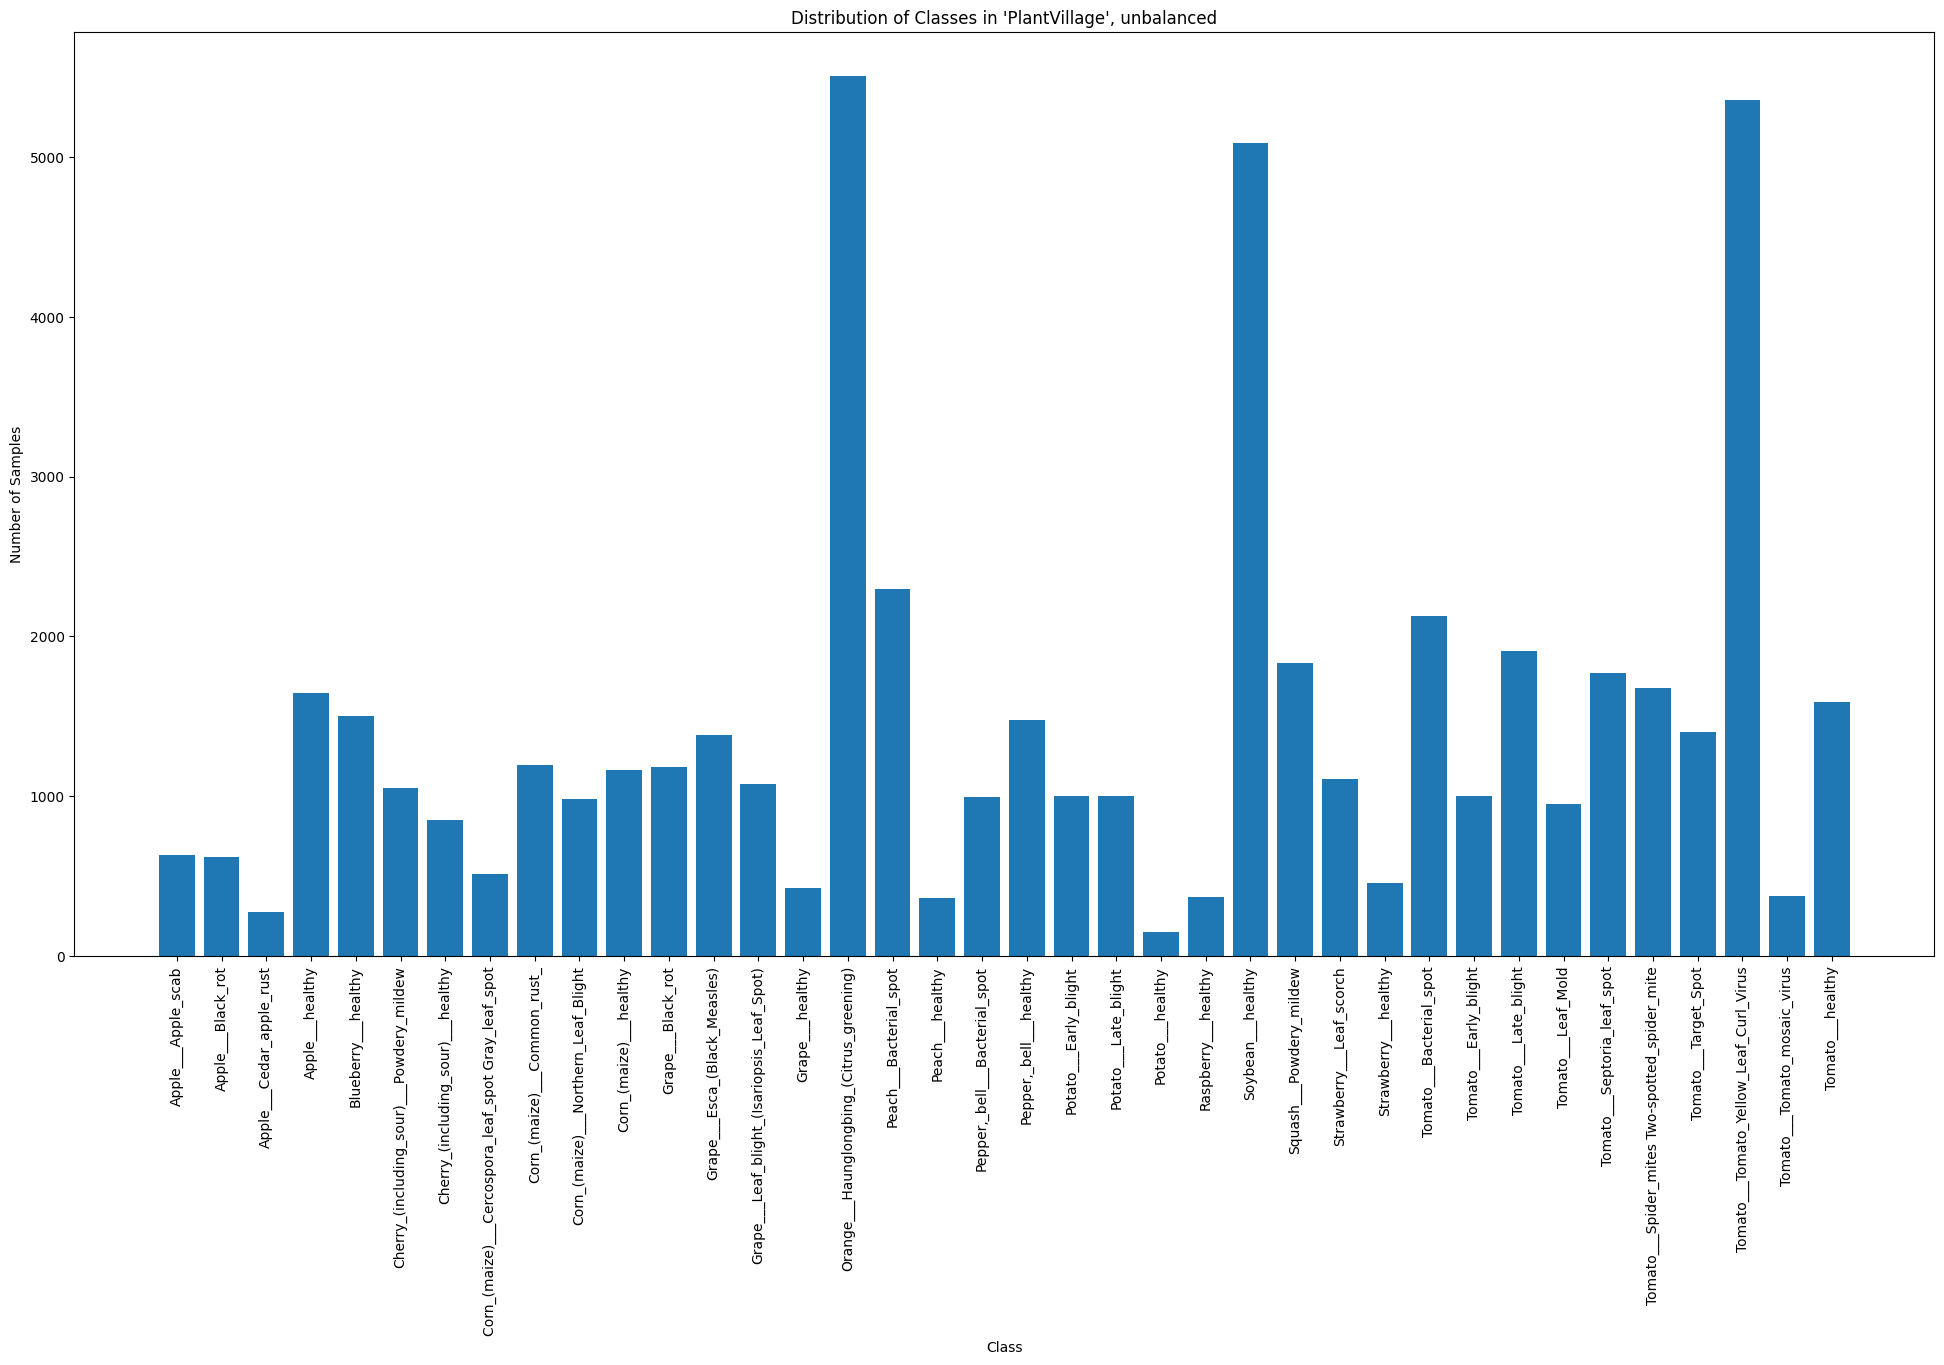

In [10]:
import matplotlib.pyplot as plt

# Count the number of samples in each class
class_counts = Counter([label_map[label] for _, label in train_dataset_color.dataset.samples])

# Create a bar chart (histogram) to visualize the class distribution
plt.figure(figsize=(24, 12))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Classes in 'PlantVillage', unbalanced")
plt.xticks(rotation=90)
plt.show()

## Model initialization

In [11]:
from torchvision import models
from torch import nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def create_model():
    # Load the pretrained VGG16 model
    model = models.vgg16(weights='DEFAULT')
    
    # Freeze all layers except the classifier (optional)
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze parameters
    
    # Modify the final  fully connected layer to match the number of classes in dataset
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    model.to(dev)
    
    return model

def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    # Move model to evaluation mode
    model.eval()

    # Disable gradient computation (faster inference)
    with torch.no_grad():
        progress_bar = tqdm(enumerate(data_loader), desc="Evaluating", total=len(data_loader))
        for batch_idx, (images, labels) in progress_bar:
            images, labels = images.to(dev), labels.to(dev)  # Move to GPU if available

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class predictions

            # Update counter
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix({"Accuracy": correct / total * 100})

            # Accumulate predictions and labels for other overall metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * (correct / total)
    cm = confusion_matrix(all_labels, all_predictions)
    precision = 100 * precision_score(all_labels, all_predictions, average='macro')
    recall = 100 * recall_score(all_labels, all_predictions, average='macro')
    f1 =  100 * f1_score(all_labels, all_predictions, average='macro')
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    return {"confusion_matrix": cm, "accuracy": accuracy, "precision": precision, "recall": recall,
            "f1": f1, "per_class_acc": per_class_acc}

def plot_confusion_matrix(cm, class_names, header):
    plt.figure(figsize=(24, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(header)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## Training

In [12]:
from torch.optim import Adam

# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 2

def train_model(model, data_loader):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    # Move model to training mode
    model.train()
    # Training of the model
    for epoch in range(EPOCHS):
        progress_bar = tqdm(enumerate(data_loader), desc=f"Epoch {epoch + 1}/{EPOCHS}", total=len(data_loader))
        for batch_idx, (images, labels) in progress_bar:
            images, labels = images.to(dev), labels.to(dev)  # Move to GPU if available
    
            # Zero gradients
            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # Backward pass
            loss.backward()
            optimizer.step()
    
            progress_bar.set_postfix({"Loss": loss.item()})
    
        """# Evaluate the model on the validation set
        if 'val_loader' in locals():
            val_accuracy = evaluate_model(model, val_loader)
            print(f"Validation Accuracy: {val_accuracy:.2f}%")""";

results = []

# Train the model and evaluate the model on the test set, colored samples
print("Training model with colored samples...")
model01 = create_model()
train_model(model01, train_loader_color)
results01 = evaluate_model(model01, test_loader_color)
results01['model_name'] = "Colored"
results.append(results01)
print("done!")

# Train the model and evaluate the model on the test set, segmented samples
print("Training model with segmented samples...")
model02 = create_model()
train_model(model02, train_loader_segmented)
results02 = evaluate_model(model02, test_loader_segmented)
results02['model_name'] = "Segmented"
results.append(results02)
print("done!")

Training model with colored samples...


Evaluating: 100%|███████████████████████████████████████████████████| 170/170 [01:05<00:00,  2.59it/s, Accuracy=94.5]


done!
Training model with segmented samples...


Evaluating: 100%|███████████████████████████████████████████████████| 170/170 [01:02<00:00,  2.71it/s, Accuracy=90.8]

done!


## Evaluation

,Model,Accuracy (%),Precision (%),Recall (%),F1 score (%)
0,Colored,94.54,93.35,93.24,93.00
1,Segmented,90.79,89.07,90.59,89.32


,Accuracy per class,Colored,Segmented
0,Apple___Apple_scab,93.50,93.97
1,Apple___Black_rot,98.36,97.52
2,Apple___Cedar_apple_rust,93.88,95.45
3,Apple___healthy,96.50,89.56
4,Blueberry___healthy,99.35,98.78
5,Cherry_(including_sour)___Powdery_mildew,98.61,95.65
6,Cherry_(including_sour)___healthy,98.84,98.92
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,73.33,69.16
8,Corn_(maize)___Common_rust_,99.57,97.74
9,Corn_(maize)___Northern_Leaf_Blight,90.86,93.43


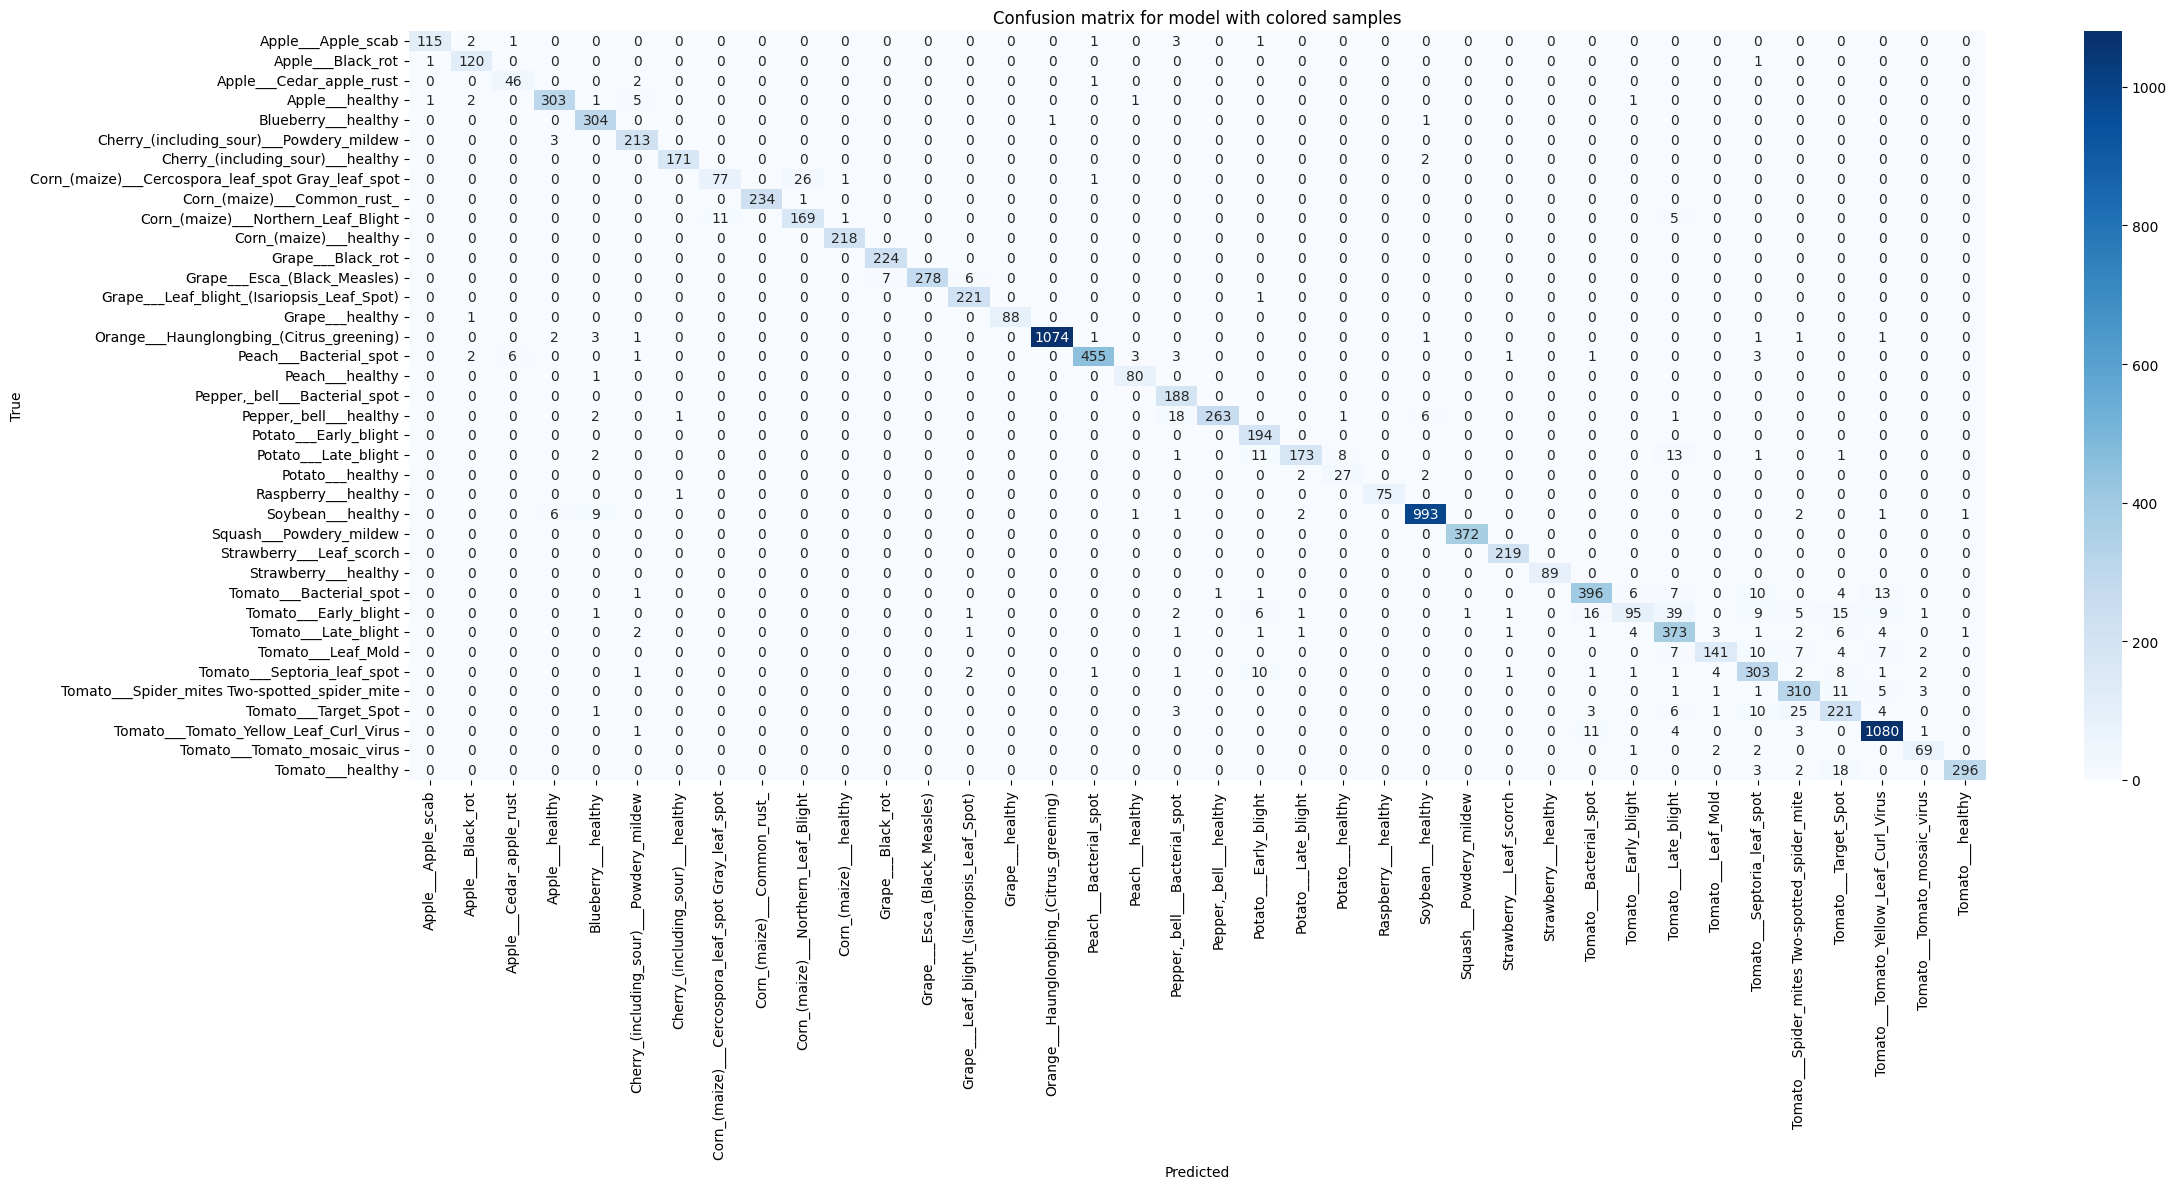

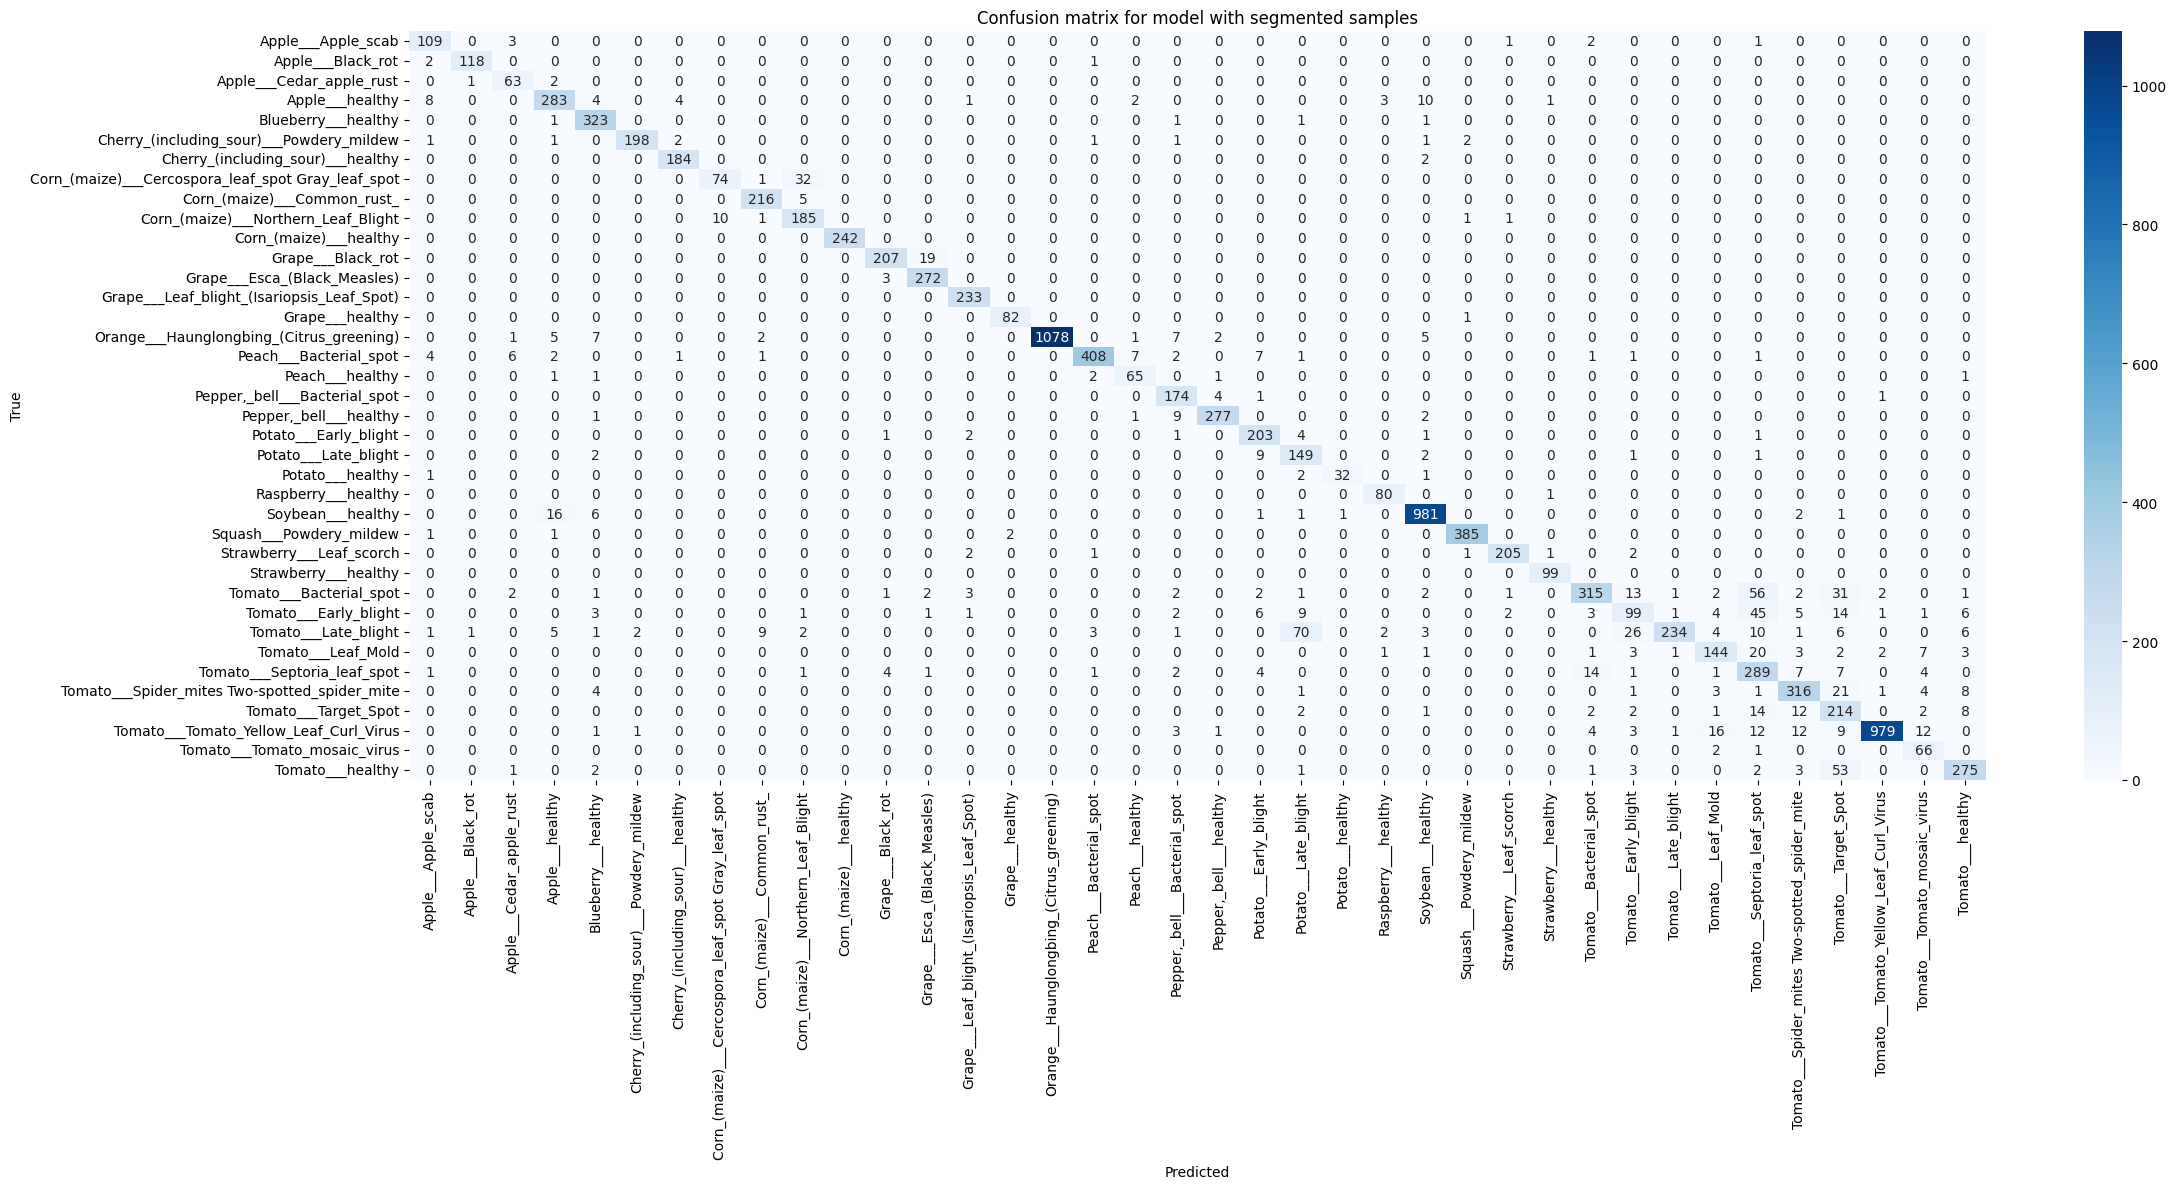

In [13]:
# Build a table for overall metrics (accuracy, precision, recall and F1)
summary_table = pd.DataFrame([{'Model': res['model_name'], 'Accuracy (%)': res['accuracy'],
                            'Precision (%)': res['precision'], 'Recall (%)': res['recall'],
                            'F1 score (%)': res['f1']} for res in results])
summary_table = summary_table.round(2)
display(summary_table)

# Build a table for accuracy per classes
per_class_acc_dict = {'Accuracy per class': label_map.values()}
for res in results:
    model_name = res['model_name']
    accs = (res['per_class_acc'] * 100).round(2)  # convert to % and round
    per_class_acc_dict[model_name] = accs

per_class_df = pd.DataFrame(per_class_acc_dict)
display(per_class_df)

plot_confusion_matrix(results01['confusion_matrix'], label_map.values(), "Confusion matrix for model with colored samples")
plot_confusion_matrix(results02['confusion_matrix'], label_map.values(), "Confusion matrix for model with segmented samples")